In [1]:
import importlib
from typing import Dict, Tuple
from matplotlib import pyplot as plt
from shared.definitions import TuningResult
from shared.ml_config_core import ModelTrainingResult
from shared import stats_utils
from shared.ml_config_runner import build_production_model_for_tuning_result
from shared import graph
from shared import utils
import seaborn as sns
import pandas as pd
import xgboost
from Draft import feature_builder_v2
import importlib
import xgboost as xgb

VERBOSE = False
utils.pandas_config(pd)
utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")
# Use this to select the model to train, gennerally there are certain advantages and disadvantages between using different tuning targets:
# e.g. F1 provides better classification accuracy
# PR-AUC however is only slightly worse but has much smoother probabilities which is more
# useful when when selecting thresholds for grades
INCLUDE_MODELS = [
    "BaselelineOnlyCreditRatings",
    "LGBMTuneWeightedLogLoss_Full_DS",
    "LGBMTuneAUC_Base_DS",

    "LGBMTuneAUC_Full_DS_Drop_Ratings",
    "LGBMTuneAUC_Full_DS",

    # "XGBoostTunePRAUC",
    # "XGBoostTunePRAUCRejected",
    # "CatBoostF1",
    # "XGBoostTuneF1",
]
importlib.reload(feature_builder_v2)
# features_matrix = feature_builder_v2.load_datasets_and_prepare_features(drop_meta_data=True, ds_type=feature_builder_v2.DatasetType.FULL)


<module 'Draft.feature_builder_v2' from '/home/paulius/data/projects/ppuodz-ML.4.1/Draft/feature_builder_v2.py'>

In [2]:
results_all_models: Dict[str, Tuple[TuningResult, ModelTrainingResult]] = {}

for model_key in INCLUDE_MODELS:
    tuning_result = TuningResult.load_serialized_tuning_result(model_key)

    cv_results = build_production_model_for_tuning_result(
        tuning_result=tuning_result, load_df=feature_builder_v2.load_datasets_and_prepare_features
    )
    results_all_models[model_key] = (tuning_result, cv_results)

    ModelTrainingResult.serialize_model(cv_results, model_key)

BaselelineOnlhCreditRatings: 1.3 seconds
LGBMTuneWeightedLogLoss_Full_DS: 14.6 seconds
LGBMTuneAUC_Base_DS: 7.2 seconds


index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
LGBMTuneAUC_Full_DS_Drop_Ratings: 50.1 seconds


index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
LGBMTuneAUC_Full_DS: 40.8 seconds


In [ ]:
for model_key, model_data in results_all_models.items():
    model_results = model_data[1]
    display(model_key)
    display("CV Results:")
    display(pd.Series(model_results.cv_metrics).round(3))
    display("Test Split Evaluation:")
    display(pd.Series(model_results.test_data.metrics).round(3))
    display("v2:")
    display(pd.Series(model_results.test_data.metrics_2).round(3))

In [4]:
cv_results_all_models = {k: v[1] for k, v in results_all_models.items()}

The figure layout has changed to tight


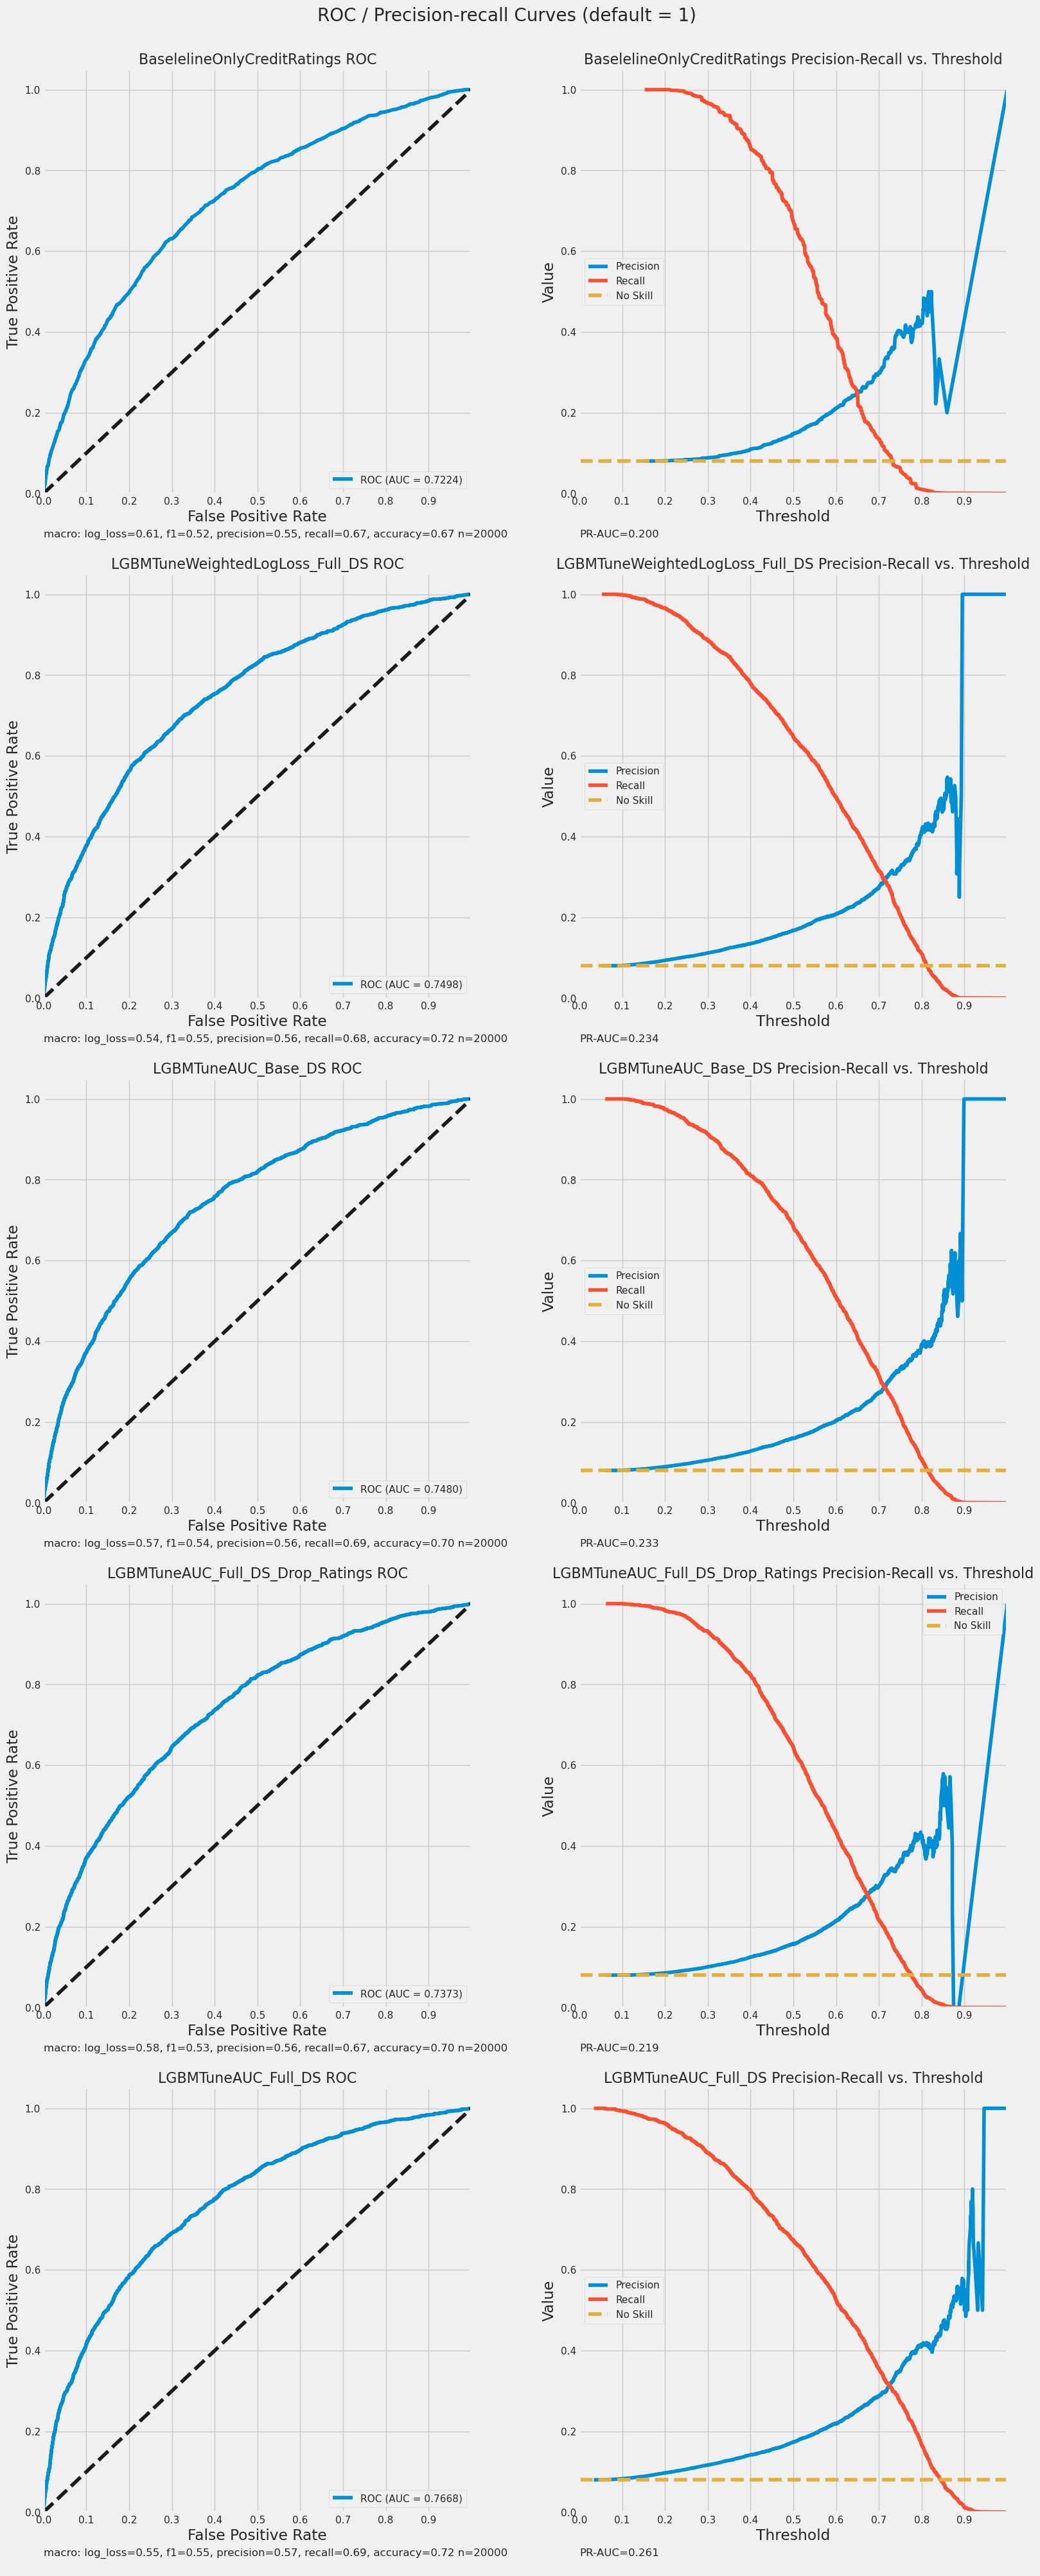

In [5]:

if len(cv_results_all_models) < 2:
    cv_results_all_models["_DUMMY"] = cv_results_all_models[list(cv_results_all_models.keys())[0]]
importlib.reload(graph)
first_model = list(cv_results_all_models.keys())[0]
graph.roc_precision_recal_grid_plot(cv_results_all_models)

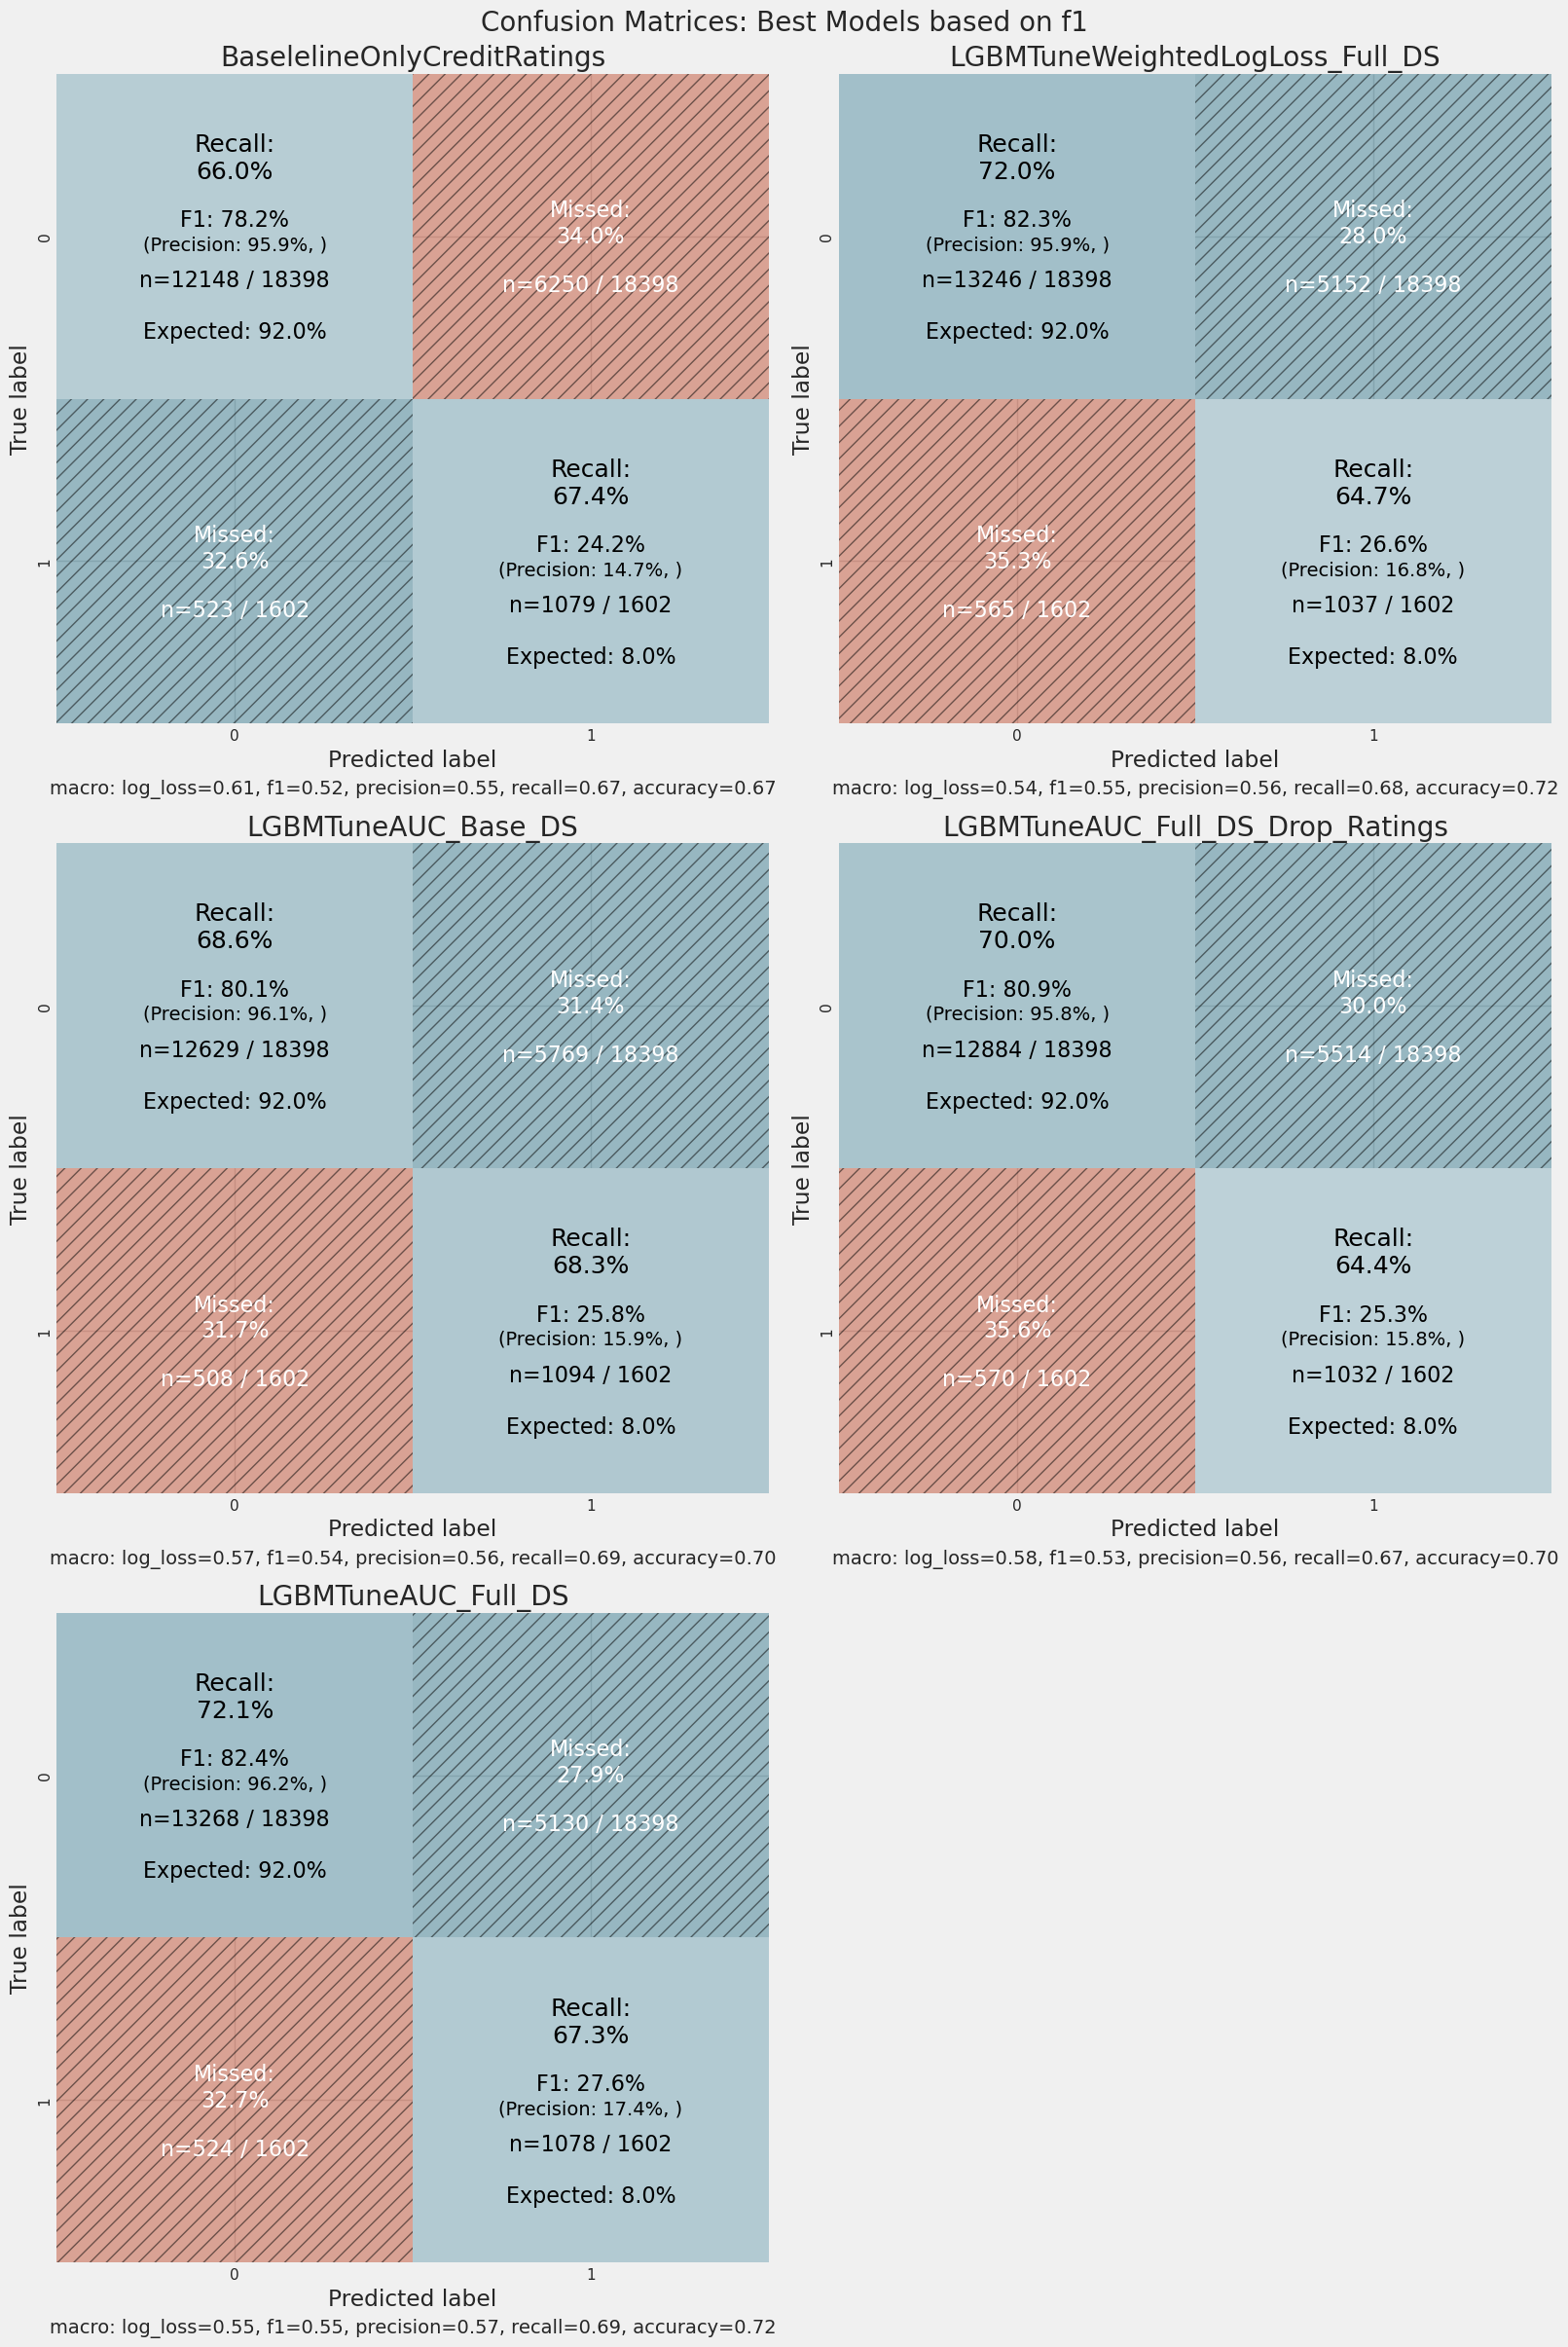

In [6]:
importlib.reload(graph)

n = len(cv_results_all_models)
columns = 2
rows = (n + 1) // columns
height = 8
width = height * columns

fig, axes = plt.subplots(
    rows, columns, figsize=(width, height * rows), constrained_layout=True
)
plt.suptitle("Confusion Matrices: Best Models based on f1", fontsize=20)

axes_flat = axes.flatten()
for i, model_key in enumerate(cv_results_all_models.keys()):
    graph.confusion_matrix_plot_v2(
        cv_results_all_models[model_key].cm_data,
        title=model_key,
        annotations=graph.make_annotations(cv_results_all_models[model_key].cv_metrics),
        ax=axes_flat[i],
    )

# Hide any unused axes
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

plt.show()

In [7]:
# importlib.reload(stats_utils)
# importlib.reload(graph)
# 
# for model_key in cv_results_all_models.keys():
#     if "Baseline" in model_key:
#         continue
#     model_config = cv_results_all_models[model_key]
#     feature_importances = stats_utils.get_model_feature_importances(
#         model_config, features_matrix
#     )
# 
#     graph.render_feature_importances_chart(
#         feature_importances=feature_importances,
#         title=f"{model_key} Importances",
#         top_n=50
#     )
#     if VERBOSE:
#         display(feature_importances)

In [8]:
# cv_results_all_models.keys()

In [15]:
from shared import pipeline

# from shared import pipeline

target_model_config = results_all_models["LGBMTuneWeightedLogLoss_Full_DS"]
features_matrix = target_model_config[0].model_pipeline_config.load_data(
    loader_function=feature_builder_v2.load_datasets_and_prepare_features)
# 
features_all, labels_all = pipeline._get_features_labels(features_matrix)
X_train, X_test, y_train, y_test = pipeline.get_deterministic_train_test_split(
    features_all, labels_all
)

X_train = X_train.drop(columns=["TARGET"])
X_test = X_test.drop(columns=["TARGET"])
# 
# importlib.reload(graph)
# for model_key, model_data in cv_results_all_models.items():
#     if "Baseline" in model_key:
#         continue
# 
#     model = cv_results_all_models[model_key].test_data.test_model.named_steps["model"]
# 
#     booster_model = model.get_booster()
#     shap_values = booster_model.predict(
#         xgboost.DMatrix(X_test, enable_categorical=True), pred_contribs=True
#     )
#     graph.render_shap_plot(shap_values, X_test, model_title=model_key)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


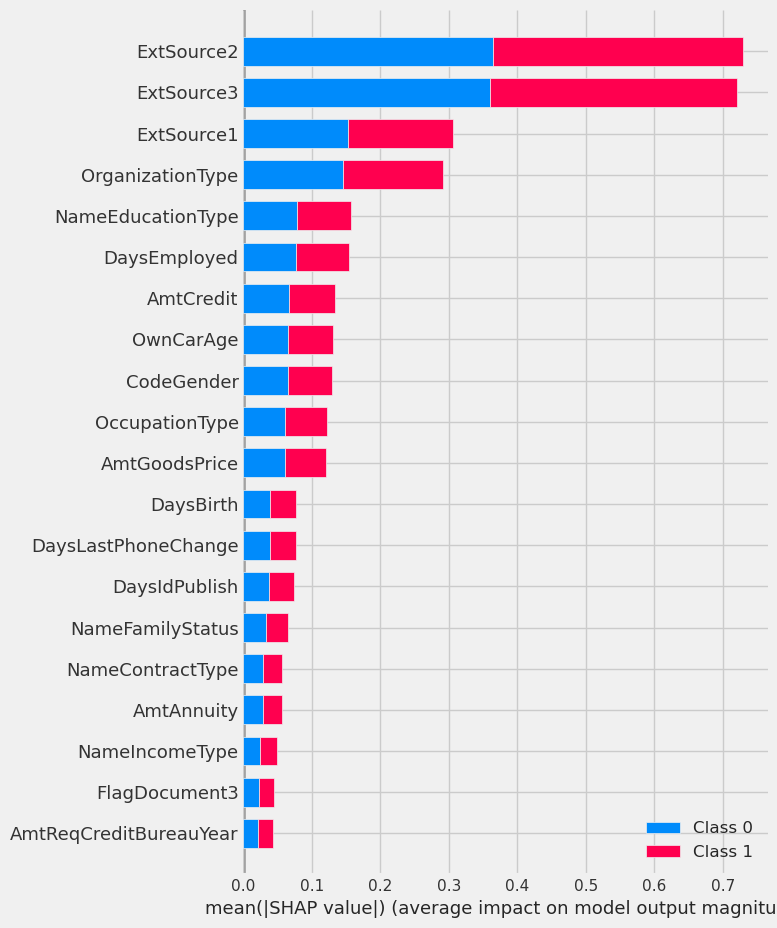

In [16]:
import shap

model = target_model_config[1].test_data.test_model.named_steps["model"]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


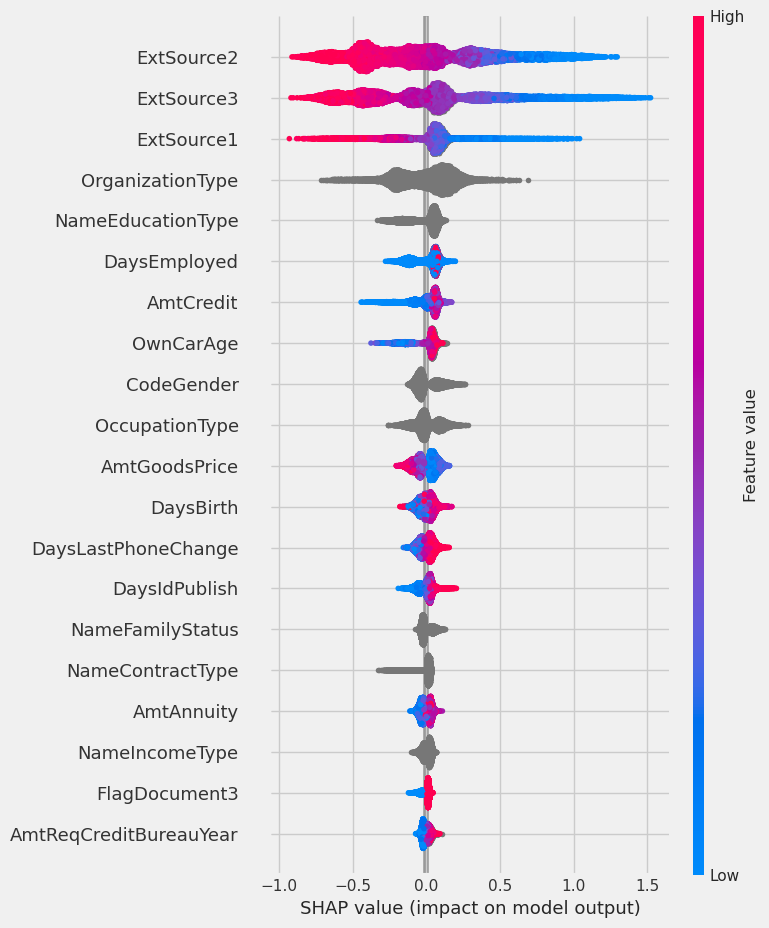

In [17]:
shap.summary_plot(shap_values[1], X_test)

In [12]:
import numpy as np

# Calculate absolute differences between predicted probabilities and actual values
predicted_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

absolute_differences = np.abs(predicted_probabilities - y_test)

# Create a DataFrame for easier handling
differences_df = pd.DataFrame({
    'absolute_difference': absolute_differences,
    'index': range(len(y_test))
})

# Sort by 'absolute_difference' in descending order and select the top N
N = 10
top_differences_df = differences_df.nlargest(N, 'absolute_difference')

# If you want a random sample of N from these top differences
random_sample_top_diff = top_differences_df.sample(n=N, random_state=42)  # Use a fixed seed for reproducibility

# Get the indices of the selected samples
selected_indices = random_sample_top_diff['index'].values

# Use these indices to select instances from X_test or y_test if needed
selected_samples_X_test = X_test.iloc[selected_indices]
selected_samples_y_test = y_test.iloc[selected_indices]


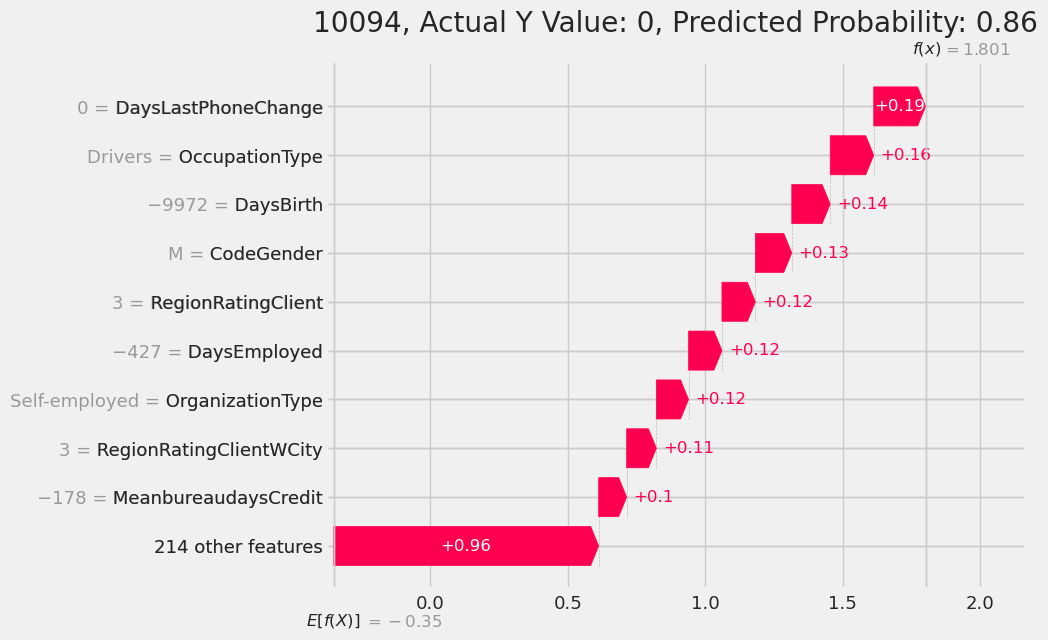

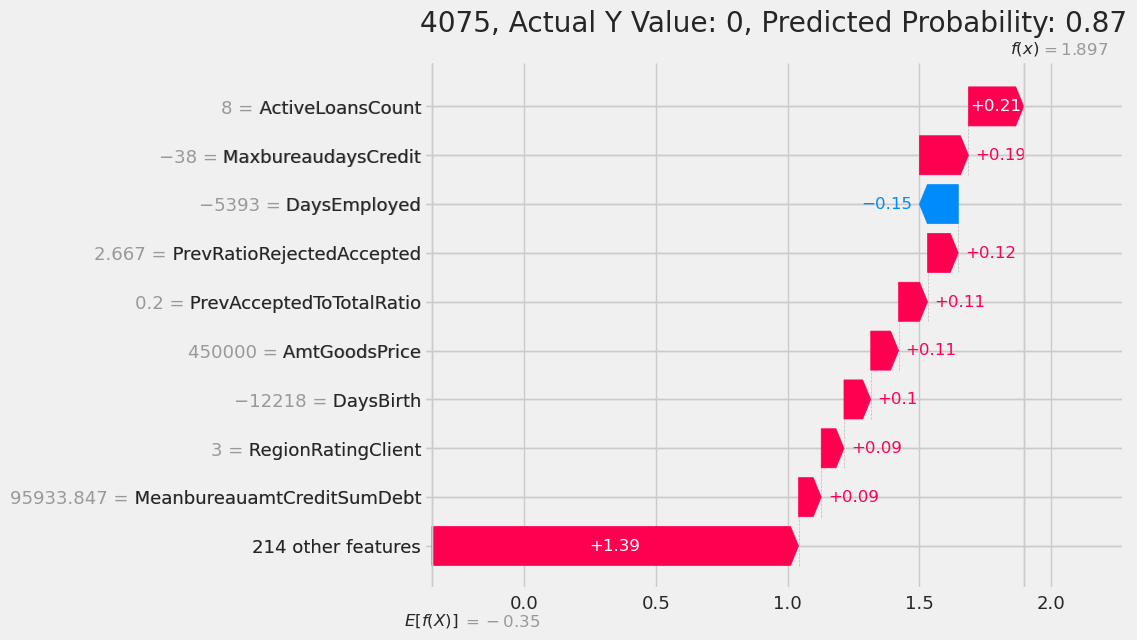

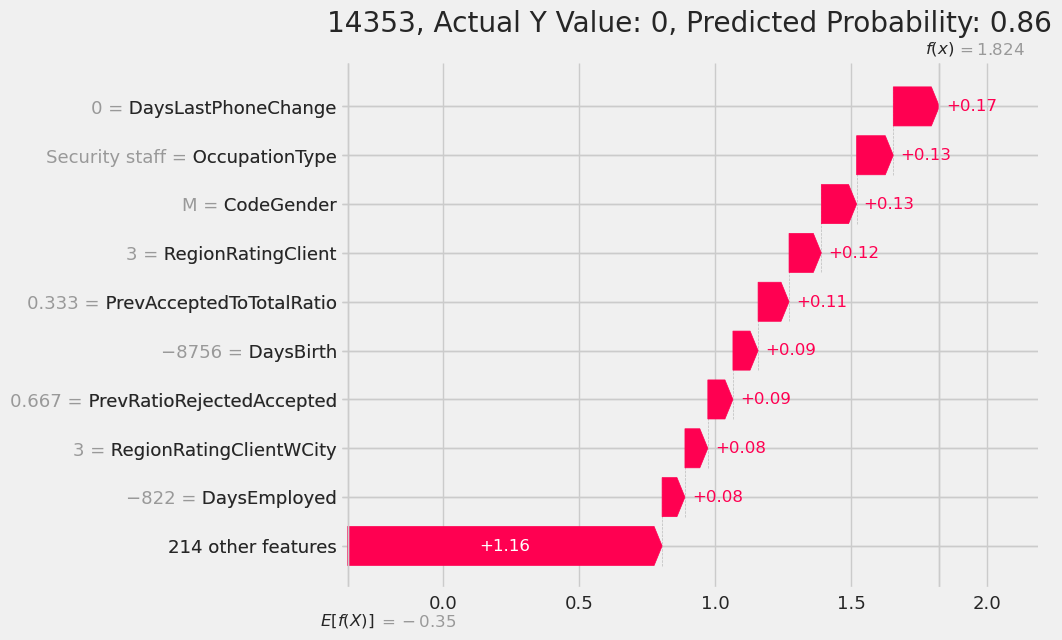

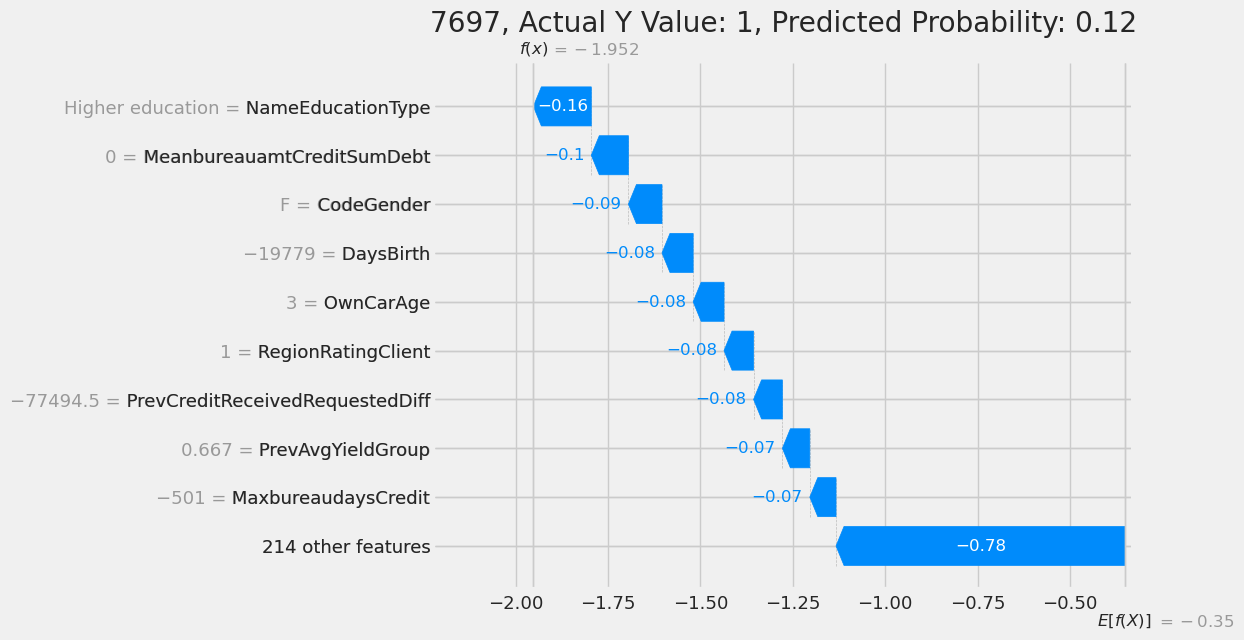

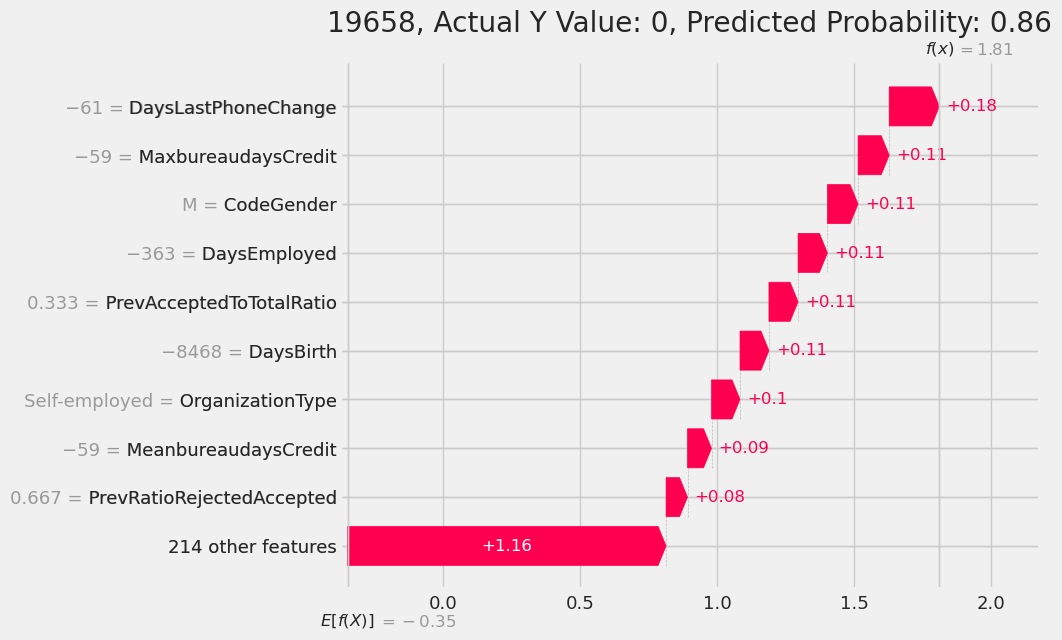

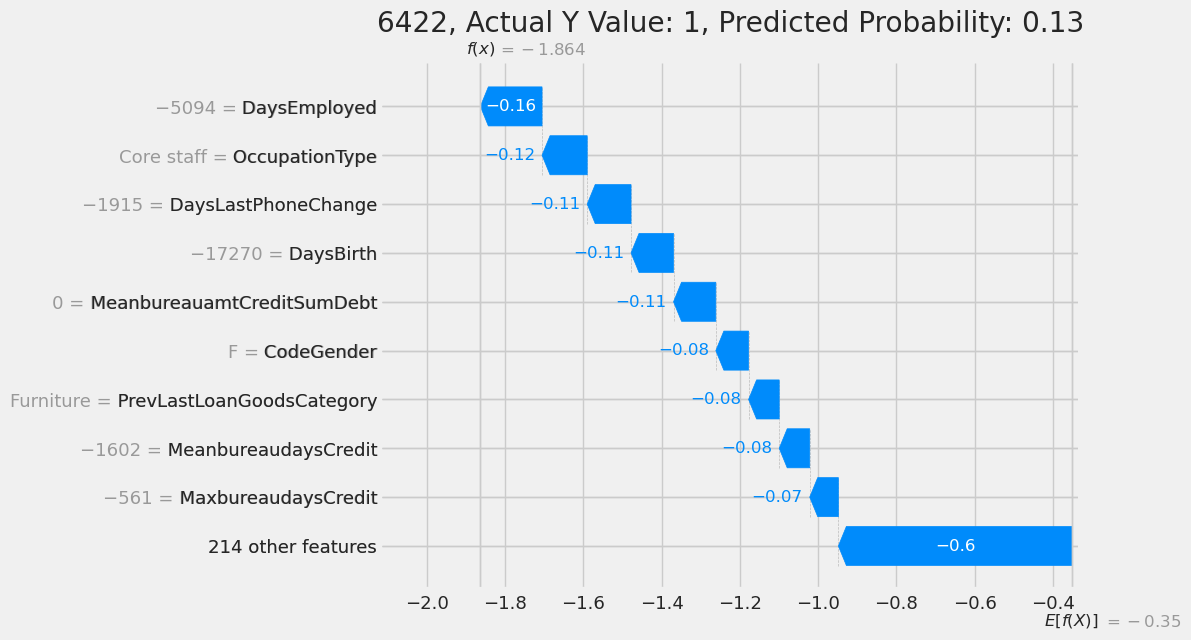

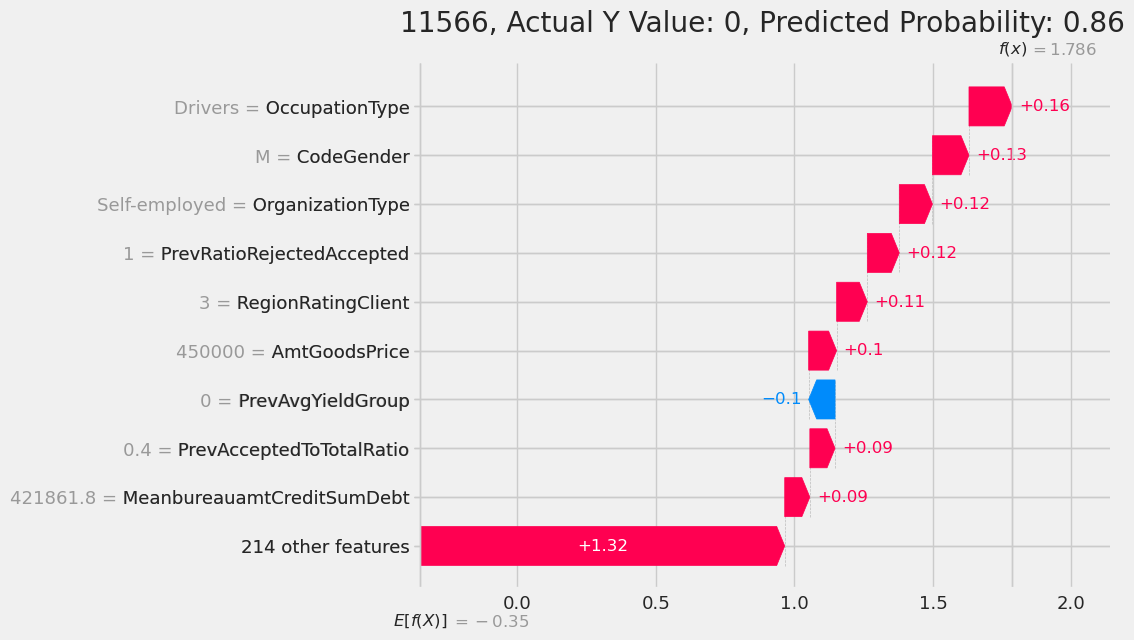

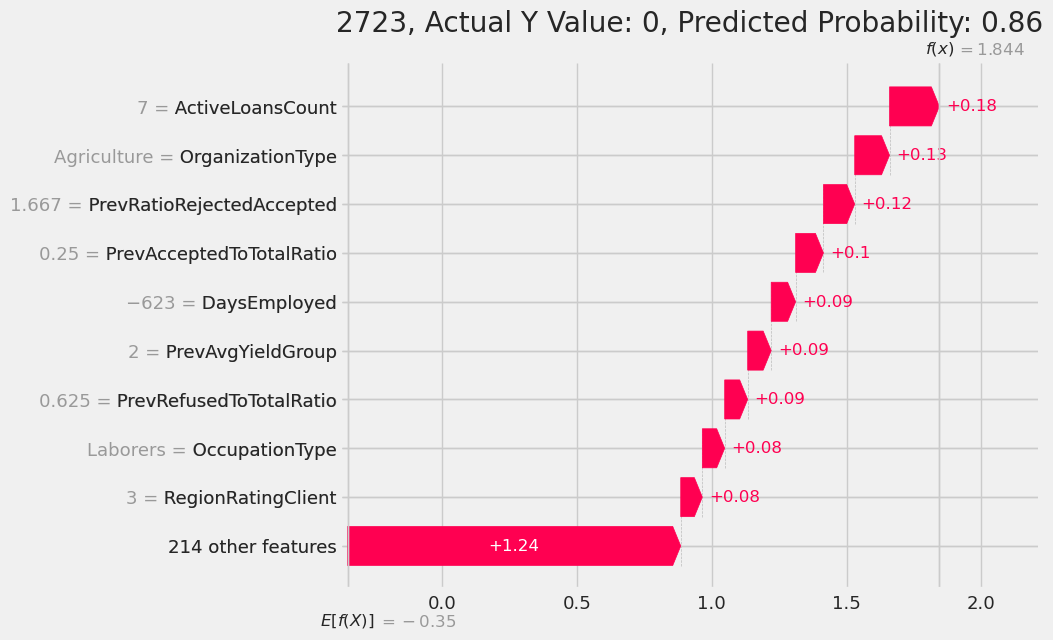

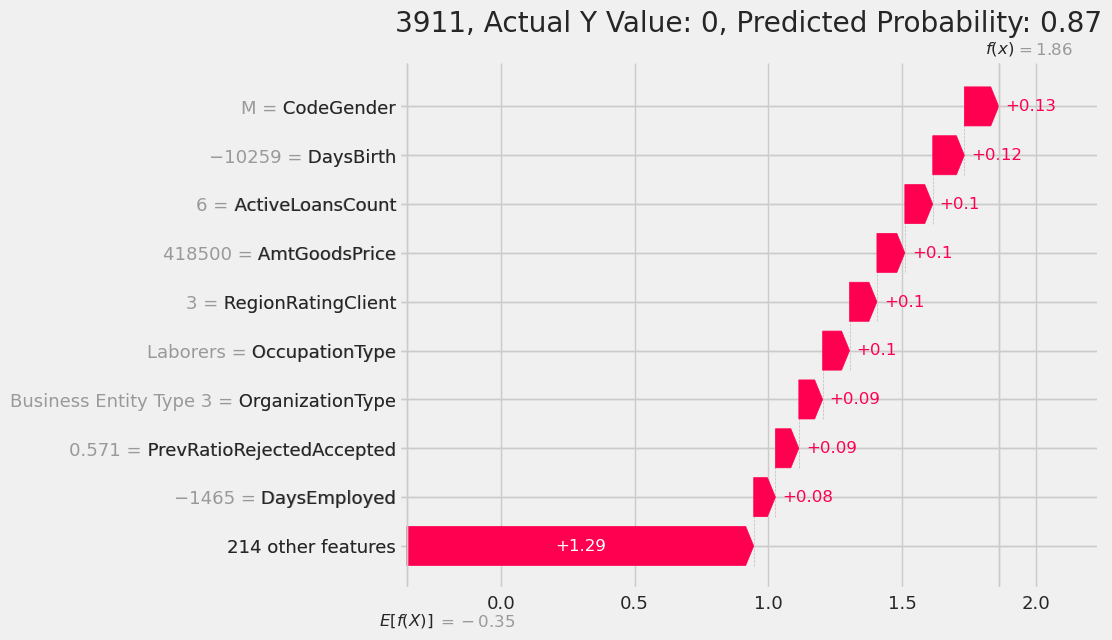

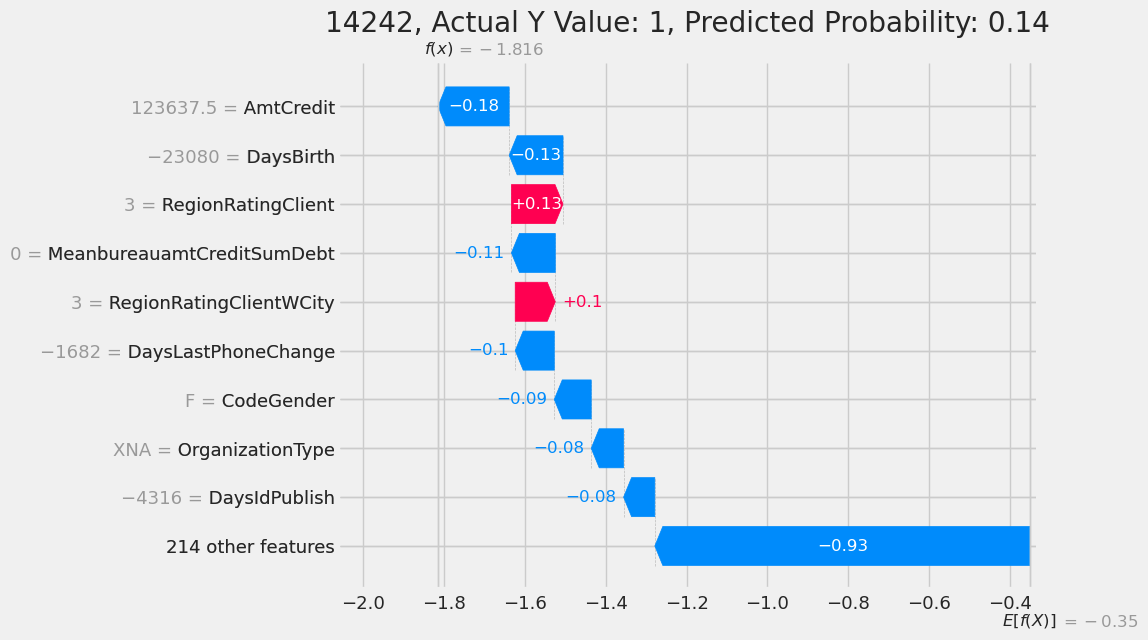

In [13]:

for i in selected_indices:
    # Create the SHAP Explanation object for the selected sample
    shap_explanation = shap.Explanation(values=shap_values[1][i],
                                        base_values=explainer.expected_value[1],
                                        data=X_test.iloc[i].values,
                                        feature_names=X_test.columns.tolist())

    # Calculate predicted probability for the selected sample
    predicted_probability = model.predict_proba(X_test.iloc[i:i + 1])[0, 1]

    # Retrieve the actual y value for the selected sample
    actual_y_value = y_test.iloc[i]

    # Generate the waterfall plot
    shap.plots.waterfall(shap_explanation, show=False)

    # Adding a title with the sample index, actual y value, and predicted probability
    plt.title(f"{i}, Actual Y Value: {actual_y_value}, Predicted Probability: {predicted_probability:.2f}")
    plt.show()


In [18]:
cm_target_model_key = "LGBMTuneWeightedLogLoss_Full_DS"
cm_target_model = cv_results_all_models[cm_target_model_key]

target_cm_data = cm_target_model.test_data
target_cm_data_sorted = target_cm_data.probabilities.sort_values(by=1).reset_index(
    drop=True
)
target_cm_data_sorted
# target_cm_data_sorted["value"] = target_cm_data.y_test

,0,1
0,0.947516,0.052484
1,0.943064,0.056936
2,0.940220,0.059780
3,0.938277,0.061723
4,0.937626,0.062374
...,...,...
19995,0.112637,0.887363
19996,0.112020,0.887980
19997,0.111296,0.888704
19998,0.107375,0.892625


In [19]:
prediction_data = target_cm_data.probabilities.copy()
prediction_data["value"] = target_cm_data.y_test

In [20]:
prediction_data

,0,1,value
149688,0.245557,0.754443,0
7641,0.530602,0.469398,0
151557,0.763802,0.236198,0
248912,0.725231,0.274769,0
54556,0.543385,0.456615,0
...,...,...,...
198793,0.654334,0.345666,0
166657,0.290184,0.709816,0
255248,0.899158,0.100842,0
100848,0.690435,0.309565,0


In [21]:
target_cm_data.probabilities

,0,1
149688,0.245557,0.754443
7641,0.530602,0.469398
151557,0.763802,0.236198
248912,0.725231,0.274769
54556,0.543385,0.456615
...,...,...
198793,0.654334,0.345666
166657,0.290184,0.709816
255248,0.899158,0.100842
100848,0.690435,0.309565


In the finance industry, loan grades (or credit scores) are a crucial part of risk management, helping lenders assess the creditworthiness of borrowers. These grades are typically determined based on various factors, including the borrower's credit history, income stability, debt-to-income ratio, and more. The grades reflect the estimated risk of default, and they directly influence the interest rate offered to the borrower. Commonly, loan grades are categorized from 'A' (lowest risk) to 'G' (highest risk), although the specific categories can vary by institution.

A (Lowest Risk): Below 1% default rate. Borrowers with excellent credit histories and very low risk of default.
B: 1% to 3% default rate. Borrowers with good credit histories and low risk of default.
C: 3% to 7% default rate. Borrowers with average credit histories and moderate risk of default.
D: 7% to 15% default rate. Borrowers with below-average credit histories and higher risk of default.
E: 15% to 25% default rate. Borrowers with poor credit histories and very high risk of default.
F and G (Highest Risk): Above 25% default rate. Borrowers with very poor credit histories and extremely high risk of default.



In [22]:
# Assuming source_df_grades_summary and target_cm_data are already defined
# Sort probabilities for cumulative proportion mapping

# Define the data as a dictionary
data = {
    "index": ["A", "B", "C", "D", "E", "F", "G"],
    "Proportion": [0.12, 0.14, 0.17, 0.14286, 0.14286, 0.14286, 0.14286],
    "Loan_Status_Ratio": [1, 1, 1, 1, 1, 1, 1]
}

# Convert the dictionary to a DataFrame
source_df_grades_summary = pd.DataFrame(data)

# Set the 'index' column as the index of the DataFrame
source_df_grades_summary = source_df_grades_summary.set_index('index')

source_df_grades_summary["Cumulative"] = source_df_grades_summary["Proportion"].cumsum()
source_df_grades_summary["Cumulative"] = source_df_grades_summary["Cumulative"].clip(
    upper=1
)

sections = []

palette = sns.color_palette("YlOrRd", n_colors=len(source_df_grades_summary))

start_color = "grey"
colors = (
        [start_color] + palette + ["red"]
)  # Ensure "red" is used for the merged EFG section

i = 0
previous_cumulative = 0

# efg_weights = source_df_grades_summary.loc["E":"G", "Counts"]
# efg_risks = source_df_grades_summary.loc["E":"G", "Loan_Status_Ratio"]
# weighted_avg_risk_efg = np.average(efg_risks, weights=efg_weights)

# Find thresholds in target_cm_data that match cumulative proportions
for grade, row in source_df_grades_summary.iterrows():
    if grade == source_df_grades_summary.index[0]:
        start = 0.0
    else:
        start = target_cm_data_sorted[1].quantile(previous_cumulative)

    end = target_cm_data_sorted[1].quantile(row["Cumulative"])

    #  merge grades E, F, G
    # if grade == "E":
    #     continue
    # elif grade == "F":
    #     continue
    # elif grade == "G":
    #     label = "E-F-G Grade"
    #     color = "red"
    # else:
    if True:
        label = f"{grade} Grade"
        color = colors[i]

    # if grade == "G":
    #     description = f"Expected D. R.: {weighted_avg_risk_efg:.1%}"
    # else:
    #     description = f"Expected D. R.: {row['Loan_Status_Ratio']:.1%}"

    sections.append(
        {
            "label": label,
            "start": start,
            "end": end,
            "color": color,
            "description": "",
        }
    )
    if grade != "G":
        i += 1
    previous_cumulative = row["Cumulative"]
sections[-1]["end"] = 1.35
# sections




[{'label': 'A Grade', 'start': 0.0, 'end': 0.11815261405186228, 'color': 'grey', 'description': 'Default rate up to 1%'}, {'label': 'B Grade', 'start': 0.11815261405186228, 'end': 0.36124656963654694, 'color': (0.996078431372549, 0.8497808535178777, 0.46145328719723183), 'description': 'Default rate up to 3%'}, {'label': 'C Grade', 'start': 0.36124656963654694, 'end': 0.552433958942383, 'color': (0.9920953479430988, 0.5490657439446367, 0.23418685121107266), 'description': 'Default rate up to 7%'}, {'label': 'D Grade', 'start': 0.552433958942383, 'end': 0.732126470818953, 'color': (0.8866897347174163, 0.09956170703575548, 0.11072664359861592), 'description': 'Default rate up to 15%'}, {'label': 'E-F-G Grade', 'start': 0.732126470818953, 'end': 1.0, 'color': 'red', 'description': 'Default rate up to 100%'}]


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

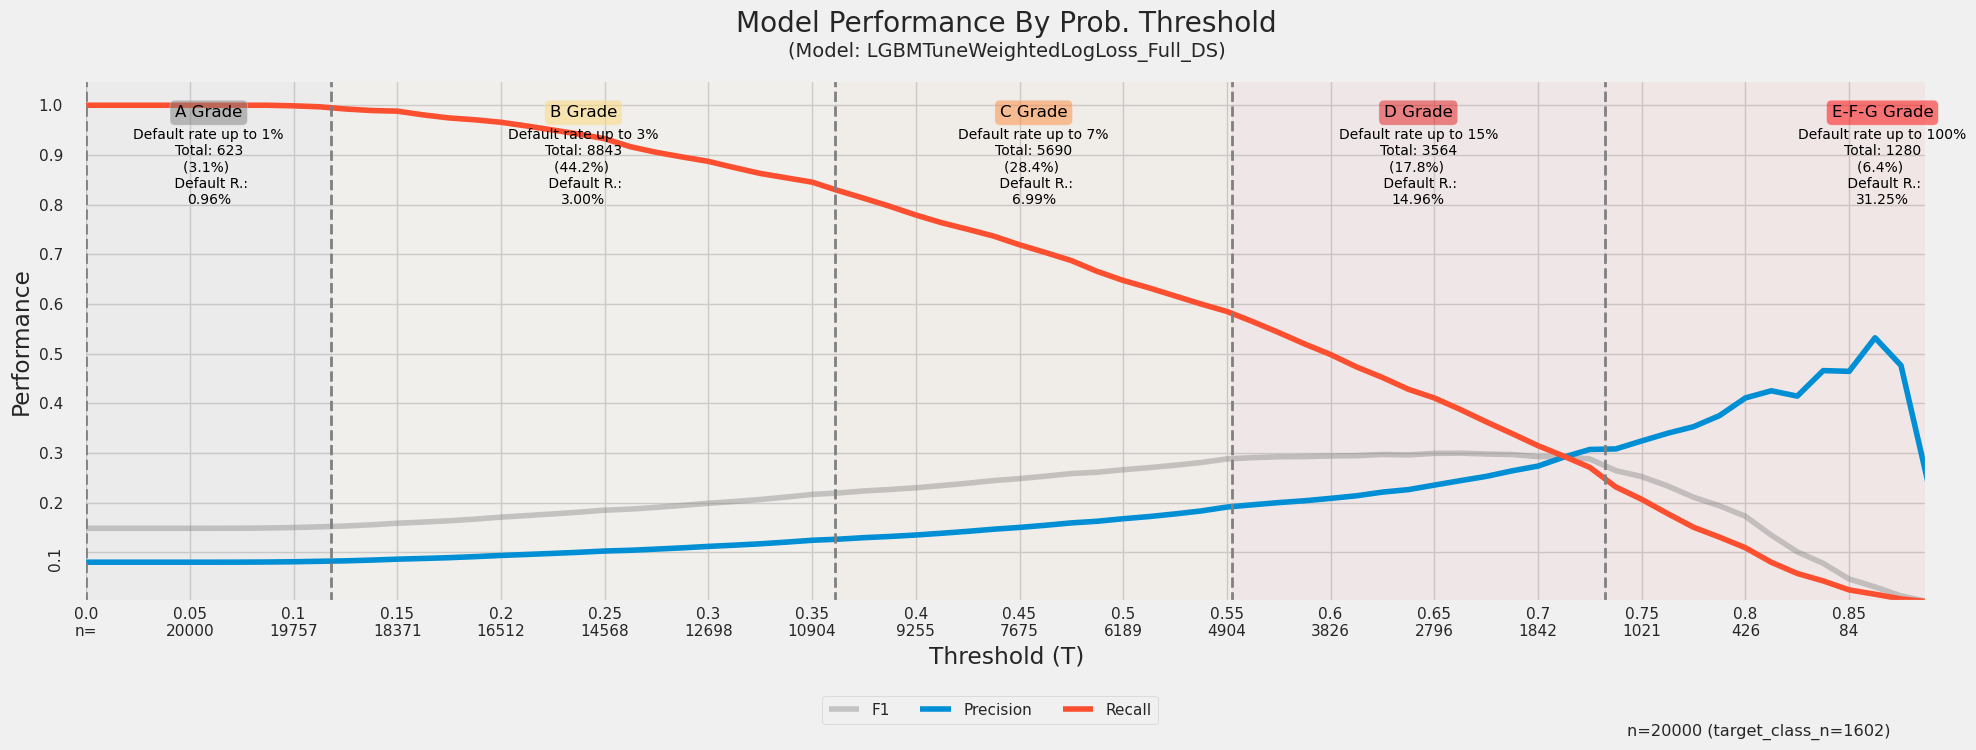

`The chart shows the  performance of the if only individual with stroke Prob. > T are selected. Additionally the overlay indicates the number of people whose predicted P is in an given range. The overlays can be used to selected the most at risk individual based on the probability predicted for them`

In [23]:
import numpy as np
import pandas as pd


# def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
#     # Default rates dictionary included within the function
#     default_rates = {'A': 0.01, 
#                      'B': 0.03, 
#                      'C': 0.07,
#                      'D': 0.15, 
#                      'E-F-G': 1}
#                      # 'E': 0.25,
#                      # 'F': 0.35, 
#                      # 'G': 1.0}
#     
#     palette = sns.color_palette("YlOrRd", n_colors=len(default_rates))
#     
#     start_color = "grey"
#     colors = (
#         [start_color] + palette + ["red"]
#     )  # Ensure "red" is used for the merged EFG section
# 
#     # Prepare the data
#     prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)
#     prediction_data_sorted['cumulative_default'] = prediction_data_sorted['value'].cumsum()
#     prediction_data_sorted['cumulative_non_default'] = np.arange(1, len(prediction_data_sorted) + 1) - prediction_data_sorted['cumulative_default']
#     prediction_data_sorted['default_rate'] = prediction_data_sorted['cumulative_default'] / (prediction_data_sorted['cumulative_non_default'] + prediction_data_sorted['cumulative_default'])
# 
#     # Initialize the list to store sections
#     sections = []
#     start = 0.0  # Initial start value
#     
#     i = 0
#     for grade, rate in default_rates.items():
#         # Identify the threshold for the current grade
#         mask = prediction_data_sorted['default_rate'] <= rate
#         if mask.any():
#             max_prob = prediction_data_sorted.loc[mask, 1].max()
#             end = max_prob
#         else:
#             end = 1.0
#         
#         
#         
#         # Append the section
#         sections.append({
#             "label": f"{grade} Grade",
#             "start": start,
#             "end": end,
#             "color": colors[i],
#             "description": f"Default rate up to {rate:.1%}"
#         })
#         
#         i+=1
#         start = end  # Update start for the next grade
#     
#     # Ensure the last section end is set correctly
#     if sections:
#         sections[-1]['end'] = 1.0
#     
#     return sections
# 
# # Assuming prediction_data is defined
# Example usage
def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
    # Default rates dictionary is now internal to the function
    default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E-F-G': 1.0}
    # default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E': 0.25, 'F': 0.35, 'G': 1.0}

    # Adjust the color palette as specified
    palette = sns.color_palette("YlOrRd", n_colors=len(default_rates) - 2)
    start_color = "grey"
    colors = [start_color] + palette + ["red"]

    # Sort by predicted probability of default
    prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)

    sections = []
    previous_threshold = 0.0
    color_index = 0

    for grade, max_default_rate in default_rates.items():
        # Filter data for loans not yet assigned to a more secure grade
        remaining_loans = prediction_data_sorted[prediction_data_sorted[1] > previous_threshold]

        # Calculate cumulative defaults and loans for remaining loans
        remaining_loans['cumulative_defaults'] = remaining_loans['value'].cumsum()
        total_loans = np.arange(1, len(remaining_loans) + 1)
        remaining_loans['default_rate'] = remaining_loans['cumulative_defaults'] / total_loans

        # Find the threshold where the default rate exceeds the grade's max default rate
        valid_loans = remaining_loans[remaining_loans['default_rate'] <= max_default_rate]
        if not valid_loans.empty:
            threshold = valid_loans[1].max()
        else:
            # If no loans meet the criteria, the threshold is the previous threshold
            threshold = previous_threshold

        # Append section with calculated thresholds and color
        sections.append({
            "label": f"{grade} Grade",
            "start": previous_threshold,
            "end": threshold,
            "color": colors[color_index],
            "description": f"Default rate up to {max_default_rate * 100:.0f}%"
        })

        # Update for the next iteration
        previous_threshold = threshold
        color_index += 1

    # Ensure the last section goes up to 1
    if sections:
        sections[-1]['end'] = 1.0

    return sections


sections = calculate_thresholds(prediction_data)
print(sections)
importlib.reload(stats_utils)
importlib.reload(graph)
summary_desc = "`The chart shows the  performance of the if only individual with stroke Prob. > T are selected. Additionally the overlay indicates the number of people whose predicted P is in an given range. The overlays can be used to selected the most at risk individual based on the probability predicted for them`"
from IPython.core.display import Markdown

graph.plot_threshold_metrics_v2(
    target_cm_data,
    0,
    1,
    sections=sections,
    model_name=cm_target_model_key,
    class_pos=1,
    include_vars=["f1", "precision", "recall"],
    show_threshold_n=True,
    log_x=False,
)
display(Markdown(summary_desc))